# Immunofluorescence Cardiomyocyte Segmentation on QuPath Selected ROI

In this notebook we will provide a workflow demonstration to load RAW CZI IF image from Axioscan 7, together with user predefined ROI from QuPath to perform cell segmentation based on membrane stained cardiomyocyte channel (AF488-WGA). The process includes 3 steps, including:

1. Effective data I/O and data normalization
2. Inference of 2D [PlantSeg](https://github.com/hci-unihd/plant-seg) pre-trained model
3. Post segmentation filtering

In [47]:
from aicsimageio import AICSImage
from aicsimageio.writers.ome_tiff_writer import OmeTiffWriter
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from skimage import exposure
import SimpleITK as sitk
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
from plantseg.predictions.functional.predictions import unet_predictions
from plantseg.segmentation.functional.segmentation import *
from skimage.segmentation import relabel_sequential
from cellpose import core, utils, io, models, metrics, plot
from cellpose.plot import *
from skimage.measure import regionprops, regionprops_table
from sklearn.model_selection import ParameterGrid
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/si

In [3]:
channels = {
    "DAPI": "Nuclei",
    "AF488-WGA": "Boundary",
    "AF555-PDGFRa": "Fibroblast",
    "AF647-Ki67": "Proliferation",
    "AF751-CD31": "Endothelial Cells",
    "AF594-cTnl": "Cardiomyocytes"
}

channels_cmap = {
    "DAPI": "Blues",
    "AF488-WGA": "Greys",
    "AF555-PDGFRa": "RdPu",
    "AF647-Ki67": "Reds",
    "AF751-CD31": "Greens",
    "AF594-cTnl": "PuRd"
}

## Data IO

In [4]:
# IMG_PATH = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no17_NS_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488.czi"
# OBJ_PATH = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no17_NS_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488.czi - Scene #3.geojson"
# OUT_DIR = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no17_NS_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488_res"
# scene_idx=2

IMG_PATH = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no20_FR_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488.czi"
OBJ_PATH = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no20_FR_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488.czi - Scene #2.geojson"
OUT_DIR = "/media/Data3/Jacky/Data/myocardial_cells/20240109 segmentation Jacky/no20_FR_lv7_cTnI-594_CD31-750_PDGFRa-555_Ki67-647_WGA-488_res"
scene_idx=1

In [5]:
img = AICSImage(IMG_PATH)
img.set_scene(scene_idx)
img_dask = img.get_image_dask_data("CYX")
img_dask.persist()
img_dask

dask.array<transpose, shape=(6, 13128, 12368), dtype=uint16, chunksize=(6, 3344, 3344), chunktype=numpy.ndarray>

In [6]:
# scaled image
img_dask_scaled = img_dask[:,::10,::10]
img_dask_scaled = img_dask_scaled.compute()

In [7]:
# load cropped region file
regions = gpd.read_file(OBJ_PATH)
regions

,id,objectType,name,geometry
0,b9ae4f18-b408-4124-94c1-e3225b6f7cd6,annotation,BZ1,"POLYGON ((7963.00000 5221.00000, 8963.00000 52..."
1,4888d783-fab9-47fc-84ed-4f57b73f8e09,annotation,BZ3,"POLYGON ((6944.00000 5576.00000, 7944.00000 55..."
2,6b6225b4-3333-40bd-a430-19b431d52ad8,annotation,BZ4,"POLYGON ((1746.00000 6620.00000, 2746.00000 66..."
3,67843846-74d8-4b4e-9036-650020cff625,annotation,BZ2,"POLYGON ((3573.00000 6056.00000, 4573.00000 60..."
4,0f00f674-3312-44aa-bac4-fb0703cb2411,annotation,RZ2,"POLYGON ((6434.00000 9782.00000, 7434.00000 97..."
5,d8237935-2eac-40d4-9412-ffa38c373b8f,annotation,RZ1,"POLYGON ((7520.00000 9225.00000, 8520.00000 92..."


[(7963.0, 5221.0), (8963.0, 5221.0), (8963.0, 6221.0), (7963.0, 6221.0), (7963.0, 5221.0)]
[(6944.0, 5576.0), (7944.0, 5576.0), (7944.0, 6576.0), (6944.0, 6576.0), (6944.0, 5576.0)]
[(1746.0, 6620.0), (2746.0, 6620.0), (2746.0, 7620.0), (1746.0, 7620.0), (1746.0, 6620.0)]
[(3573.0, 6056.0), (4573.0, 6056.0), (4573.0, 7056.0), (3573.0, 7056.0), (3573.0, 6056.0)]
[(6434.0, 9782.0), (7434.0, 9782.0), (7434.0, 10782.0), (6434.0, 10782.0), (6434.0, 9782.0)]
[(7520.0, 9225.0), (8520.0, 9225.0), (8520.0, 10225.0), (7520.0, 10225.0), (7520.0, 9225.0)]


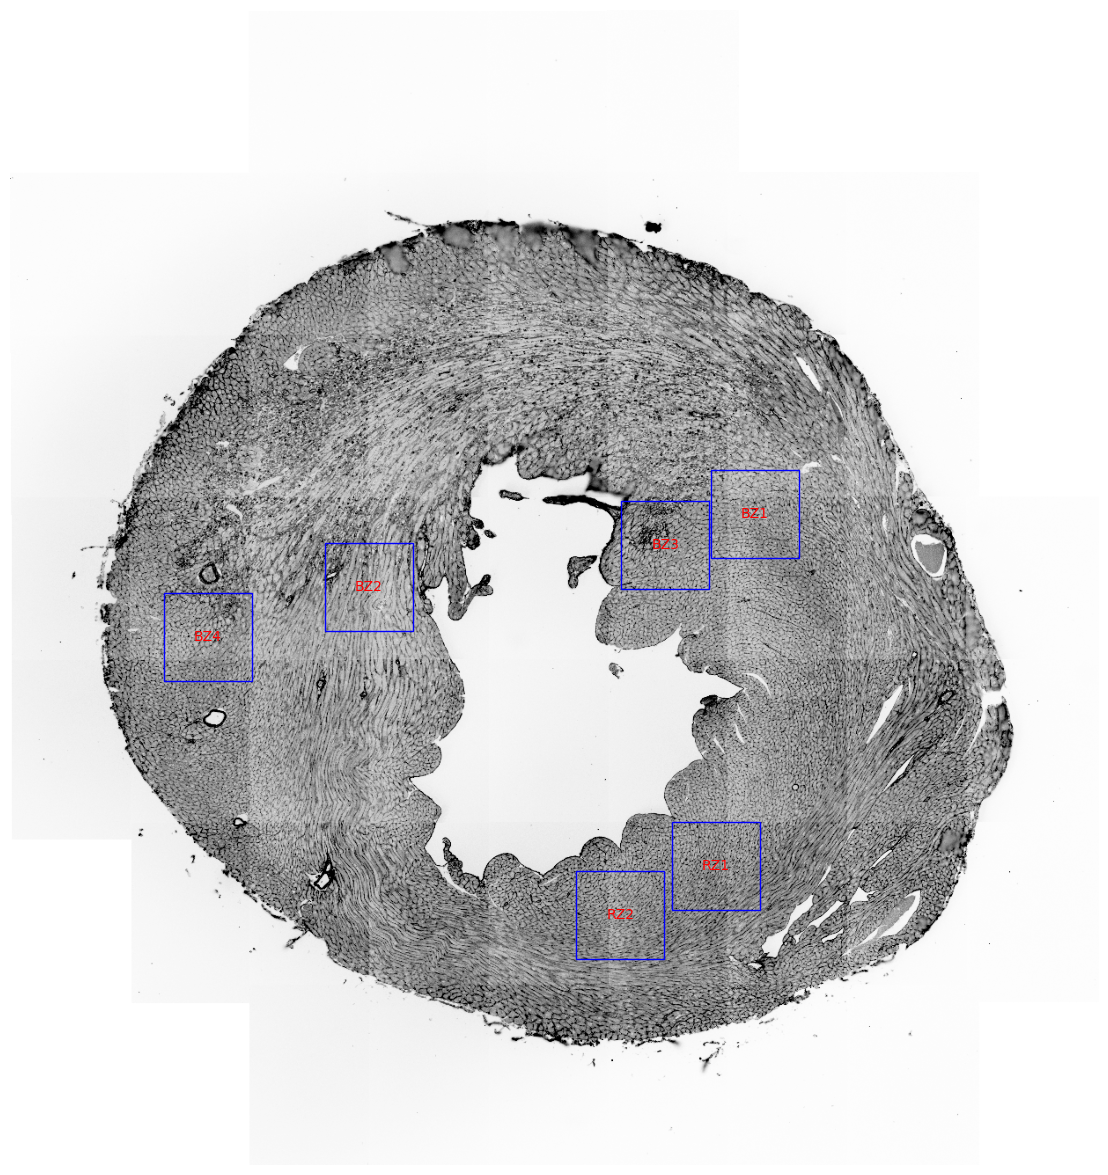

In [8]:
# Create a Rectangle patch
figure, ax = plt.subplots(1,1,figsize=(15,15))
frame = img_dask_scaled[1,:,:]
tail = 1
pl, pu = np.percentile(np.ravel(frame), (tail, 100-tail))
ax.imshow(exposure.rescale_intensity(frame, in_range=(pl, pu),out_range=(0,255)),cmap="Greys")
ax.axis("off")

for idx, row in regions.iterrows():
    coordinates = list(row["geometry"].exterior.coords)
    print(coordinates)
    SUBREGION = [coordinates[0][0], coordinates[0][1], coordinates[2][0]-coordinates[0][0],coordinates[2][1]-coordinates[0][1]]
    # SUBREGION = [coordinates[0][0], coordinates[0][1], coordinates[0][0]-coordinates[2][0],coordinates[0][1]-coordinates[2][1]]
    # SUBREGION = [coordinates[1][1], coordinates[0][0], coordinates[2][1]-coordinates[0][1],coordinates[2][0]-coordinates[0][0]]
    
    rect = patches.Rectangle((SUBREGION[0]/10,SUBREGION[1]/10), SUBREGION[2]/10, SUBREGION[3]/10, linewidth=1, edgecolor='b', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.text(row["geometry"].centroid.x/10, row["geometry"].centroid.y/10, row["name"], ha="center", va="center",color="r")

## Segmentation

In [111]:
res = []
param_grid = {
    "beta": [ round(x,1) for x in np.arange(0.3,1.05,0.1)],
    "post_minsize": [ round(x,1) for x in np.arange(90,110,10)],
}

params = list(ParameterGrid(param_grid))

for idx, row in tqdm(regions.iterrows(),desc="Segmenting"):
    coordinates = list(row["geometry"].exterior.coords)
    SUBREGION = [coordinates[0][0], coordinates[0][1], coordinates[2][0]-coordinates[0][0],coordinates[2][1]-coordinates[0][1]]

    img_dask_subset = img_dask[1,SUBREGION[1]:SUBREGION[1]+SUBREGION[3],SUBREGION[0]:SUBREGION[0]+SUBREGION[2]]

    frame_rescaled = exposure.rescale_intensity(img_dask_subset, in_range=(pl, pu),out_range=(0,1))

    # pred = unet_predictions(frame_rescaled[np.newaxis,:,:],"confocal_2D_unet_ovules_ds2x",patch=[1,1024,1024])
    pred = unet_predictions(frame_rescaled[np.newaxis,:,:],"lightsheet_2D_unet_root_ds1x",patch=[1,1000,1000])
    # pred = unet_predictions(frame_rescaled[np.newaxis,:,:],"confocal_2D_unet_sa_meristem_cells",patch=[1,1024,1024])

    for param in tqdm(params, desc="Post processing"):
        beta = param["beta"]
        post_mini_size = param["post_minsize"]

        mask = mutex_ws(pred,superpixels=None,beta=beta,post_minsize=post_mini_size,n_threads=6)
        mask_relab, fw, inv = relabel_sequential(mask[0,:,:])
        outlines = utils.masks_to_outlines(mask_relab)

        outX, outY = np.nonzero(outlines)
        img0 = image_to_rgb(frame_rescaled, channels=[0,0])
        imgout= img0.copy()
        imgout[outX, outY] = np.array([255,0,0]) # pure red

        # perform region properties measurements
        props = regionprops(mask_relab)
        props_table = regionprops_table(mask_relab,properties=["centroid","area","area_convex","area_filled","axis_major_length","axis_minor_length","eccentricity","feret_diameter_max","perimeter","perimeter_crofton","solidity"])
        props_df = pd.DataFrame.from_dict(props_table)

        res.append({
            "name": row["name"],
            "beta": beta,
            "post_mini_size": post_mini_size,
            "img": img_dask_subset,
            "pred": pred[0,:,:],
            "mask": mask_relab,
            "overlay": imgout,
            "props": props,
            "props_df": props_df
        })
        # break
    # break

Segmenting: 0it [00:00, ?it/s]

2024-01-15 17:24:45,614 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]
/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/elf/segmentation/multicut.py:59: RuntimeWarning: divide by zero encountered in log
  costs = np.log((1. - costs) / costs) + np.log((1. - beta) / beta)
/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/elf/segmentation/multicut.py:59: RuntimeWarning: divide by zero encountered in log
  costs = np.log((1. - costs) / costs) + np.log((1. - beta) / beta)
Post processing: 100%|██████████| 16/16 [00:54<00:00,  3.39s/it]
Segmenting: 1it [01:02, 62.84s/it]

2024-01-15 17:25:48,596 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/elf/segmentation/multicut.py:59: RuntimeWarning: divide by zero encountered in log
  costs = np.log((1. - costs) / costs) + np.log((1. - beta) / beta)
/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/elf/segmentation/multicut.py:59: RuntimeWarning: divide by zero encountered in log
  costs = np.log((1. - costs) / costs) + np.log((1. - beta) / beta)
Post processing: 100%|██████████| 16/16 [00:55<00:00,  3.44s/it]
Segmenting: 2it [02:06, 63.41s/it]

2024-01-15 17:26:52,399 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]
/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/elf/segmentation/multicut.py:59: RuntimeWarning: divide by zero encountered in log
  costs = np.log((1. - costs) / costs) + np.log((1. - beta) / beta)
/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/elf/segmentation/multicut.py:59: RuntimeWarning: divide by zero encountered in log
  costs = np.log((1. - costs) / costs) + np.log((1. - beta) / beta)
Post processing: 100%|██████████| 16/16 [00:58<00:00,  3.68s/it]
Segmenting: 3it [03:14, 65.36s/it]

2024-01-15 17:28:00,705 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/elf/segmentation/multicut.py:59: RuntimeWarning: divide by zero encountered in log
  costs = np.log((1. - costs) / costs) + np.log((1. - beta) / beta)
/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/elf/segmentation/multicut.py:59: RuntimeWarning: divide by zero encountered in log
  costs = np.log((1. - costs) / costs) + np.log((1. - beta) / beta)
Post processing: 100%|██████████| 16/16 [01:05<00:00,  4.09s/it]
Segmenting: 4it [04:29, 69.11s/it]

2024-01-15 17:29:20,537 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/elf/segmentation/multicut.py:59: RuntimeWarning: divide by zero encountered in log
  costs = np.log((1. - costs) / costs) + np.log((1. - beta) / beta)
/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/elf/segmentation/multicut.py:59: RuntimeWarning: divide by zero encountered in log
  costs = np.log((1. - costs) / costs) + np.log((1. - beta) / beta)
Post processing: 100%|██████████| 16/16 [01:02<00:00,  3.88s/it]
Segmenting: 5it [05:45, 71.74s/it]

2024-01-15 17:30:32,751 [MainThread] INFO PlantSeg - Using batch size of 1 for prediction


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/elf/segmentation/multicut.py:59: RuntimeWarning: divide by zero encountered in log
  costs = np.log((1. - costs) / costs) + np.log((1. - beta) / beta)
/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/elf/segmentation/multicut.py:59: RuntimeWarning: divide by zero encountered in log
  costs = np.log((1. - costs) / costs) + np.log((1. - beta) / beta)
Post processing: 100%|██████████| 16/16 [01:00<00:00,  3.81s/it]
Segmenting: 6it [06:56, 69.45s/it]


In [105]:
props_df = res[0]["props_df"]
props_df

,centroid-0,centroid-1,area,area_convex,area_filled,axis_major_length,axis_minor_length,eccentricity,feret_diameter_max,perimeter,perimeter_crofton,solidity
0,5.030151,52.834171,199,242,199,20.910688,15.145431,0.689494,24.331050,64.420310,68.529786,0.822314
1,5.015351,671.160088,456,477,456,46.075208,14.001065,0.952712,48.093659,107.698485,104.786083,0.955975
2,53.720804,938.014270,5326,7527,5326,171.363953,46.923694,0.961780,186.037631,473.167568,451.861550,0.707586
3,5.240942,964.876812,552,616,552,54.783499,13.783086,0.967833,53.235327,122.870058,120.510395,0.896104
4,25.543827,171.725520,7986,10526,7986,263.553091,48.692747,0.982785,252.794383,595.747258,567.485334,0.758693
...,...,...,...,...,...,...,...,...,...,...,...,...
360,994.191532,885.933468,496,590,496,58.185917,12.963943,0.974864,61.522354,130.976659,131.236463,0.840678
361,994.863636,388.441558,154,168,154,22.152311,10.053796,0.891079,23.706539,55.556349,55.352239,0.916667
362,986.691228,993.298246,285,321,285,26.655450,15.139054,0.823061,26.248809,73.006097,72.091986,0.887850
363,990.891037,52.929701,569,597,569,37.563488,19.881680,0.848446,36.496575,97.698485,95.305489,0.953099


beta: 0.8
post_mini_size: 90


/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,centroid-0,centroid-1,area,area_convex,area_filled,axis_major_length,axis_minor_length,eccentricity,feret_diameter_max,perimeter,perimeter_crofton,solidity,class
0,3.919192,444.984848,198,214,198,24.938867,11.144838,0.894591,25.317978,61.591883,61.270633,0.925234,1
1,7.902256,187.484962,266,279,266,25.749117,13.780754,0.844730,27.294688,66.183766,65.427662,0.953405,1
2,3.631841,469.706468,201,220,201,26.738077,10.500681,0.919656,29.274562,63.349242,66.173592,0.913636,1
3,3.923077,681.224359,156,162,156,20.399944,9.998392,0.871656,19.924859,49.656854,49.759167,0.962963,1
4,7.793961,615.401421,563,648,563,38.162063,20.544839,0.842716,40.607881,107.734019,106.912240,0.868827,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,985.291751,373.892354,994,1214,994,44.728382,31.655553,0.706484,47.434165,141.083261,136.829535,0.818781,0
510,970.957126,467.432711,2519,3047,2519,74.857563,46.732934,0.781192,81.394103,232.468037,223.075037,0.826715,0
511,987.229767,826.520000,1075,1150,1075,54.983715,25.985677,0.881273,56.859476,141.012193,136.369459,0.934783,1
512,994.916318,784.523013,239,253,239,28.210361,12.053776,0.904118,30.149627,69.455844,68.529786,0.944664,1


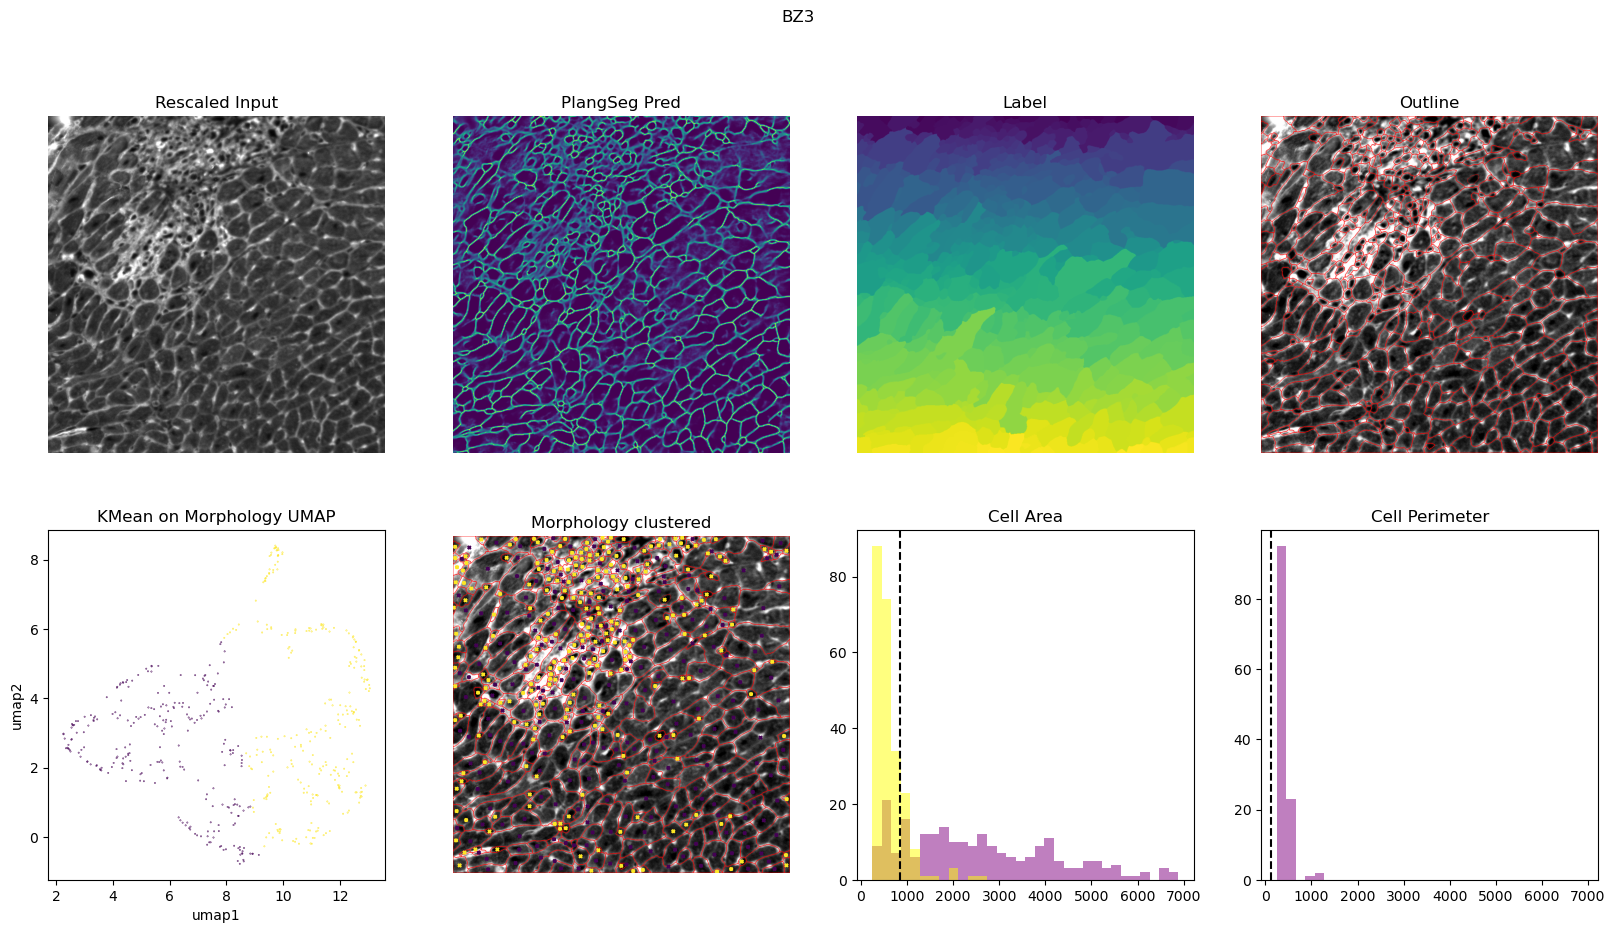

In [119]:
# plot the output
disp_idx = 26
BINS=32

print("beta:",res[disp_idx]["beta"])
print("post_mini_size:",res[disp_idx]["post_mini_size"])

fig, axs = plt.subplots(2,4,figsize=(20,10))
axs = axs.ravel()
fig.suptitle(res[disp_idx]["name"])

axs[0].imshow(res[disp_idx]["img"],cmap="gray")
axs[0].set_title('Rescaled Input')
axs[0].axis('off')

axs[1].imshow(res[disp_idx]["pred"])
axs[1].set_title('PlangSeg Pred')
axs[1].axis('off')

axs[2].imshow(res[disp_idx]["mask"])
axs[2].set_title('Label')
axs[2].axis('off')

axs[3].imshow(res[disp_idx]["overlay"])
axs[3].set_title('Outline')
axs[3].axis('off')

# scatter plot on the morphological features
cell_stats = res[disp_idx]["props_df"]
cell_stats_filtered = cell_stats[["area","area_convex","area_filled","axis_major_length","axis_minor_length","eccentricity","feret_diameter_max","perimeter","perimeter_crofton","solidity"]]
scaler = StandardScaler()
scaler.fit(cell_stats_filtered)
cell_stats_standard = scaler.transform(cell_stats_filtered)

standard_embedding = umap.UMAP(random_state=42).fit_transform(cell_stats_standard)
# Perform K-means clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(standard_embedding)
labels = kmeans.labels_
axs[4].scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=labels, s=0.1,cmap="viridis")
axs[4].set_xlabel("umap1")
axs[4].set_ylabel("umap2")
axs[4].set_title("KMean on Morphology UMAP")
cell_stats["class"] = labels

axs[5].imshow(res[disp_idx]["overlay"])
axs[5].set_title('Morphology clustered')
axs[5].axis('off')
axs[5].scatter(cell_stats["centroid-1"], cell_stats["centroid-0"], c=labels, s=5.0, cmap="viridis", marker="x")

areas = [p.area for p in res[disp_idx]["props"]]
area_0 = [a for a, keep in zip(areas, cell_stats["class"]==0) if keep]
area_1 = [a for a, keep in zip(areas, cell_stats["class"]==1) if keep]
axs[6].hist(area_0,bins=BINS,range=(np.percentile(areas,5),np.percentile(areas,95)),color="purple",alpha=0.5)
axs[6].hist(area_1,bins=BINS,range=(np.percentile(areas,5),np.percentile(areas,95)),color="yellow",alpha=0.5)
axs[6].set_title("Cell Area")
axs[6].axvline(x=np.median(areas), color='black', linestyle='--')

perimeters = [p.perimeter for p in res[disp_idx]["props"]]
perimeters_0 = [a for a, keep in zip(perimeters, cell_stats["class"]==0) if keep]
perimeters_1 = [a for a, keep in zip(perimeters, cell_stats["class"]==1) if keep]
axs[7].hist(perimeters_0,bins=BINS,range=(np.percentile(areas,5),np.percentile(areas,95)),color="purple",alpha=0.5)
axs[7].hist(perimeters_1,bins=BINS,range=(np.percentile(areas,5),np.percentile(areas,95)),color="yellow",alpha=0.5)
axs[7].set_title("Cell Perimeter")
axs[7].axvline(x=np.median(perimeters), color='black', linestyle='--')

cell_stats

# Export results

In [113]:
for i, res_ in tqdm(enumerate(res),desc="Result saving"):
    out_dir_ = os.path.join(OUT_DIR,"{}_beta-{}_pms-{}".format(res_["name"], res_["beta"], res_["post_mini_size"]))
    os.makedirs(out_dir_,exist_ok=True)
    OmeTiffWriter.save(res_["img"],os.path.join(out_dir_,"img.ome.tif"),dim_order="YX")
    OmeTiffWriter.save(res_["pred"],os.path.join(out_dir_,"pred.ome.tif"),dim_order="YX")
    OmeTiffWriter.save(res_["mask"],os.path.join(out_dir_,"mask.ome.tif"),dim_order="YX")
    OmeTiffWriter.save(res_["overlay"],os.path.join(out_dir_,"overlay.ome.tif"),dim_order="YXS")
    res_["props_df"].to_csv(os.path.join(out_dir_,"props.csv"),index=False)

Result saving: 96it [15:48,  9.88s/it]
